In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import datetime
import pickle

import ndpretty

import data_prep

In [2]:
ndpretty.default()

In [5]:
data = data_prep.load_beijing_data()


Loaded air quality data from 87 devices. No weather data for []


# PM2.5 GNN

In [7]:
data_path = "Previous work/PM2.5-GNN/data/"

know_air = np.load(data_path + "KnowAir.npy") # time × city × measure (17 features, 1 col for PM25)
cities = pd.read_table(data_path + "city.txt", delimiter=' ', header=None)
altitude = np.load(data_path + "altitude.npy")

with open(data_path + "city_dict.pkl", 'rb') as f:
    city_dict = pickle.load(f)

There aren't any NaN values in the data for PM2.5 GNN:

In [5]:
np.isnan(know_air).any()

False

For one city, multiple sensors seem to be grouped together.

In [6]:
city_dict['Beijing']

[['1001A', 116.366, 39.8673, 'Wanshouxigong'],
 ['1002A', 116.17, 40.2865, 'Dingling'],
 ['1003A', 116.434, 39.9522, 'Dongsi'],
 ['1004A', 116.434, 39.8745, 'Tiantan'],
 ['1005A', 116.473, 39.9716, 'Nongzhanguan'],
 ['1006A', 116.361, 39.9425, 'Guanyuan'],
 ['1007A', 116.315, 39.9934, 'Haidianquwanliu'],
 ['1008A', 116.72, 40.1438, 'Shunyixincheng'],
 ['1009A', 116.64399999999999, 40.3937, 'Huairouzhen'],
 ['1010A', 116.23, 40.1952, 'Changpingzhen'],
 ['1011A', 116.40700000000001, 40.0031, 'Aotizhongxin'],
 ['1012A', 116.225, 39.9279, 'Gucheng']]

The centroid of all sensor coordinates seems to be used as the cities computation location. However, the PM2.5 measurements within Beijing vary a lot. As we are focussing on Beijing, we probably shouldn't average over the whole city.

### Generate my own input data

#### `KnowAir.npy`

This file seems to be `time × city × measure` whereas `measure` contains 17 weather features and 1 column for PM2.5.

It includes no time steps, just the data. On the `time` dimension, it contains one entry every three hours.

In [7]:
data_start = pd.to_datetime("2015-01-01 00:00")
data_end = pd.to_datetime("2018-12-31 21:00")

know_air.shape[0], pd.Timedelta(data_end - data_start), (1460 * 24 + 21 + 3), (1460 * 24 + 21 + 3) / 3

(11688, Timedelta('1460 days 21:00:00'), 35064, 11688.0)

In [8]:
# know_air

In [58]:
list(data.metadata['device_id'].unique())

['dongsi',
 'tiantan',
 'guanyuan',
 'wanshouxigong',
 'aotizhongxin',
 'nongzhanguan',
 'wanliu',
 'beibuxinqu',
 'zhiwuyuan',
 'fengtaihuayuan',
 'yungang',
 'gucheng',
 'fangshan',
 'daxing',
 'yizhuang',
 'tongzhou',
 'shunyi',
 'changping',
 'mentougou',
 'pinggu',
 'huairou',
 'miyun',
 'yanqing',
 'dingling',
 'badaling',
 'miyunshuiku',
 'donggaocun',
 'yongledian',
 'yufa',
 'liulihe',
 'qianmen',
 'yongdingmennei',
 'xizhimenbei',
 'nansanhuan',
 'dongsihuan',
 '1029A',
 '1030A',
 '1031A',
 '1032A',
 '1033A',
 '1034A',
 '1035A',
 '1036A',
 '1037A',
 '1038A',
 '1039A',
 '1040A',
 '1041A',
 '1042A',
 '1043A',
 '1044A',
 '1045A',
 '1046A',
 '1047A',
 '1048A',
 '1049A',
 '1050A',
 '1051A',
 '1052A',
 '1053A',
 '1054A',
 '1055A',
 '1056A',
 '1057A',
 '1058A',
 '1059A',
 '1060A',
 '1061A',
 '1062A',
 '1063A',
 '1064A',
 '1065A',
 '1066A',
 '1067A',
 '1068A',
 '1069A',
 '1070A',
 '1071A',
 '1072A',
 '1073A',
 '1074A',
 '1075A',
 '1076A',
 '1077A',
 '1078A',
 '1079A',
 '1080A']

Unique timestamps: 29454
Total df length: 353448


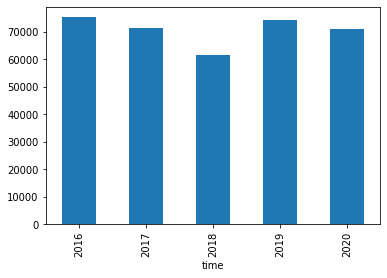

In [38]:
# rel_devices = list(data.metadata['device_id'].unique()) # all devices for now
rel_devices = ["1029A", "1037A", "1046A", "1056A", "1061A", "1065A", "1068A", "1072A", "changping", "daxing", "qianmen", "shunyi"] # for DS2

city_level_measurements = True # these have a diffent air quality format
dataset_name = "DS2_perturbed"

relevant = data.measurements
relevant = relevant[relevant['device_id'].isin(rel_devices)]

export_df = pd.DataFrame()
export_df['device_id'] = relevant['device_id']
export_df['time'] = relevant['time']

if city_level_measurements:
    export_df['2m_temperature'] = relevant['2m_temperature']
    export_df['boundary_layer_height'] = relevant['boundary_layer_height']
    export_df['relative_humidity+950'] = relevant['relative_humidity']
    export_df['surface_pressure'] = relevant['surface_pressure']
    export_df['total_precipitation'] = relevant['total_precipitation']
    export_df['u_component_of_wind+950'] = relevant['u_component_of_wind']
    export_df['v_component_of_wind+950'] = relevant['v_component_of_wind']
else:
    export_df['2m_temperature'] = relevant['temperature']
    export_df['relative_humidity+950'] = relevant['humidity'] * 100
    export_df['total_precipitation'] = relevant['precipIntensity']
    export_df['wind_speed'] = relevant['windSpeed']
    export_df['wind_direction'] = relevant['windBearing']

export_df['pm25'] = relevant['pm25']
export_df.index = relevant['time']

# drop all times at which at least one sensors has a NaN
missing_time = export_df[export_df.isnull().any(axis=1)]['time'].unique()
export_df = export_df[~export_df['time'].isin(missing_time)]

assert len(export_df) > 0, "No entries to export"

export_df.groupby(export_df['time'].dt.year).count()['time'].plot(kind='bar')

print(f"Unique timestamps: {len(export_df['time'].unique())}")
print(f"Total df length: {len(export_df)}")

In [39]:
export_df_org = export_df.copy()

perturb_atts = ["2m_temperature", "boundary_layer_height", "relative_humidity+950", "surface_pressure", "total_precipitation", "u_component_of_wind+950", "v_component_of_wind+950"]
pert_ratio = 0.5 # how many std.dev.s of noise we introduce
pert_start = pd.to_datetime("2020-12-01")
pert_end = pd.to_datetime("2020-12-31")

pert_sel = (export_df["time"] > pert_start) & (export_df["time"] < pert_end)
pert_len = len(export_df[pert_sel])

for att in perturb_atts:
    std = export_df[att].std()
    pert = (np.random.rand(pert_len) - 0.5) * std * pert_ratio
    export_df.loc[pert_sel, att] += pert

Verify that the perturbation works

<AxesSubplot:xlabel='time'>

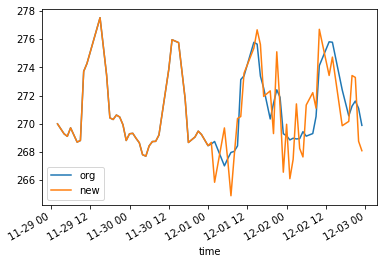

In [55]:
city = "daxing"
comp_start = pert_start - pd.Timedelta(value=2, unit='days')
comp_end = pert_start + pd.Timedelta(value=2, unit='days')

org = export_df_org[(export_df_org["device_id"] == city) & (export_df_org['time'] > comp_start) & (export_df_org['time'] < comp_end)]["2m_temperature"]
new = export_df[(export_df["device_id"] == city) & (export_df_org['time'] > comp_start) & (export_df_org['time'] < comp_end)]["2m_temperature"]
pd.concat([org, new], axis=1, keys=('org', 'new')).plot()

In [56]:
# transform from data frame to shape of KnowAir.npy
export_grouped = export_df.groupby('device_id').apply(pd.DataFrame.to_numpy)
export_devices = list(export_grouped.index)
my_know_air = list(map(lambda x: x[:,1:], export_grouped))

# time × city × measure
my_know_air = np.array(my_know_air)
my_know_air = my_know_air.swapaxes(0, 1)

In [59]:
np.save(data_path + f"KnowAir_{dataset_name}.npy", my_know_air)

#### `city.txt`

In [60]:
cities_export = pd.DataFrame({'device_id': export_devices}).merge(data.metadata, on='device_id')[['device_id', 'lon', 'lat']]

with open(data_path + f"city_{dataset_name}.txt", 'w') as city_f:
    city_f.write(cities_export.to_csv(sep=' ', header=False))

assert len(cities_export) == my_know_air.shape[1], "Mismatch between city.txt and know_air.npy"

#### Dates

<AxesSubplot:xlabel='time'>

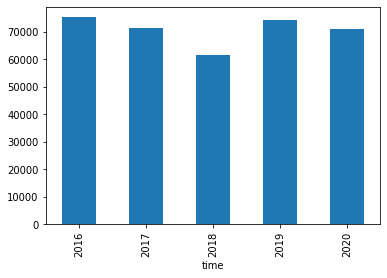

In [61]:
export_df.groupby(export_df['time'].dt.year).count()['time'].plot(kind='bar')

In [62]:
{
    'start_date': export_df['time'].min(),
    'end_date': export_df['time'].max()
}

{'start_date': Timestamp('2016-01-01 08:00:00'),
 'end_date': Timestamp('2020-12-31 23:00:00')}

## Results

Here we load the results from the GNN back to analyse them.

In [31]:
def transform_preds_back(time_npy, pred_npy, devices, data_start, melted=True):
    parsed_timestamps = pd.DataFrame(time_npy).applymap(pd.Timestamp.fromtimestamp)
    idx = np.where(parsed_timestamps[0] == data_start)[0][0] + 1  # there is an off-by-one error somewhere

    pred_index = pd.Index(parsed_timestamps[parsed_timestamps[0] == data_start].iloc[0], name='time')
    pred_df = pd.DataFrame(pred_npy[idx, :, :, 0], index=pred_index, columns=devices)

    if melted:
        return pred_df.melt(ignore_index=False, var_name='device_id', value_name='pm25')
    else:
        return pred_df

In [35]:
result_path = data_path + 'results/1_480/1/PM25_GNN/20210309210844/02/'

time_npy = np.load(result_path + 'time.npy')
pred_npy = np.load(result_path + 'predict.npy')
label_npy = np.load(result_path + 'label.npy')

#### Sanity check
Make sure that at the first (zeroth) timestamp of the prediction, we get back exactly the measurement. Otherwise, we made a mistake somewhere.

In [49]:
sample_timestamp = '2020-01-02 09:00:00'

y_pred = transform_preds_back(time_npy, pred_npy, export_devices, sample_timestamp, melted=True)
y_true = data.measurements[(data.measurements['time'] == sample_timestamp) & (data.measurements['device_id'].isin(rel_devices))]

for device in export_devices:
    true = y_true[(y_true['device_id'] == device) & (y_true['time'] == sample_timestamp)].iloc[0]['pm25']
    pred = y_pred[(y_pred['device_id'] == device) & (y_pred.index == sample_timestamp)].iloc[0]['pm25']
    assert true == pred, f"Found mismatch between measurement and prediction at measurement step for '{device}' at {sample_timestamp} -> {true} != {pred}"